In [8]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic Boosting Classifier

### **Overview**
The **Machine Gnostics Boosting Classifier** combines the state-of-the-art performance of Gradient Boosting (via XGBoost) with the robustness of **Gnostic Weighted Learning**.

Standard gradient boosting is powerful but can be prone to overfitting on noisy data, as it aggressively tries to correct all errors. The Gnostic variant identifies samples that are consistently "difficult" (often outliers or mislabeled points) and down-weights them, preventing the boosting algorithm from fixating on noise.

Key advantages:
- **High Performance**: Leverages XGBoost's efficiency and accuracy.
- **Noise Resilience**: Automatically dampens the influence of label noise.
- **Adaptive**: Updates sample weights iteratively based on model consensus.
- **Diagnostic**: Provides gnostic weights to identify potential data issues.

---

### **Theoretical Background**

The algorithm iterates through two phases:
1.  **Boosting**: A Gradient Boosting model (XGBoost) is trained on the weighted data.
2.  **Gnostic Optimization**: The model's residuals are evaluated using Thermodynamic Gnostic Entropy. Samples with high thermodynamic cost (likely errors) receive lower weights for the next iteration.

This "Gnostic Cycle" ensures the model converges to a solution that explains the reliable majority of the data while ignoring anomalies.

***

## Example 1: Robust Classification on Complex Data

We generated a dataset with complex boundaries (blobs) and introduce significant label noise. Standard boosting would likely overfit the noise, creating rugged boundaries. The Gnostic Classifier aims for smoother, more robust boundaries.

Dataset: 500 samples
Train set: 375 samples
Test set: 125 samples


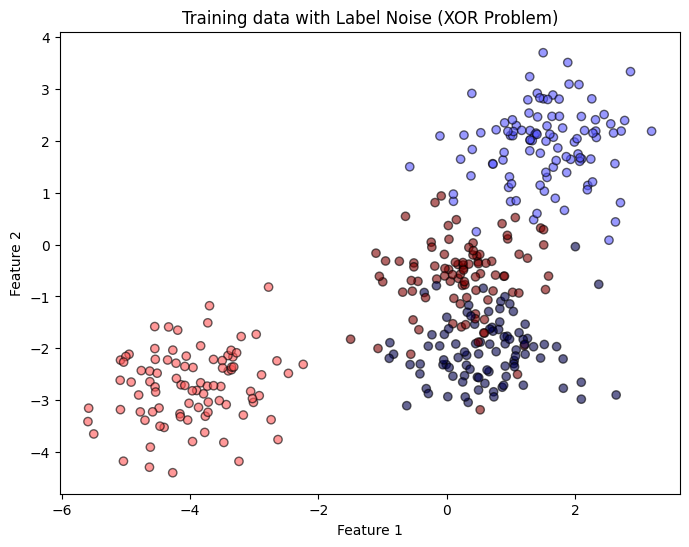

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import GnosticBoostingClassifier, train_test_split
from machinegnostics.metrics import accuracy_score, classification_report
from machinegnostics.data import make_classification_check_data
# Generate data
X, y = make_classification_check_data(n_samples=500, n_features=2, n_classes=4, separability=2)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_seed=42)

print(f"Dataset: {X.shape[0]} samples")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='seismic', edgecolors='k', alpha=0.6)
plt.title("Training data with Label Noise (XOR Problem)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [10]:
# Initialize and train Gnostic Boosting Classifier
# Note: We can pass standard XGBoost params mainly via kwargs or directly as arguments
model = GnosticBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=15,
    gnostic_weights=True,
    max_iter=10,
    tolerance=1e-1,
    verbose=False
)

print("Training Gnostic Boosting Classifier...")
model.fit(X_train, y_train)

print(f"\nModel trained successfully!")
try:
    print(f"Final loss: {model.cross_entropy_loss:.6f}")
except:
    pass

Training Gnostic Boosting Classifier...

Model trained successfully!


In [11]:
# Predict and Evaluate
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print("Model Performance:")
print("=" * 50)
print(f"Training Accuracy: {acc_train:.4f}")
print(f"Test Accuracy:     {acc_test:.4f}")
print("=" * 50)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

Model Performance:
Training Accuracy: 0.9147
Test Accuracy:     0.8960

Classification Report (Test):
Class           Precision    Recall  F1-score   Support
0                    0.76      0.97      0.85        32
1                    0.96      0.96      0.96        24
2                    1.00      1.00      1.00        35
3                    0.92      0.68      0.78        34
Avg/Total            0.91      0.90      0.89       125



### Visualization: Decision Boundaries

XGBoost creates powerful non-linear boundaries. The Gnostic weighting helps these boundaries ignore the noise.

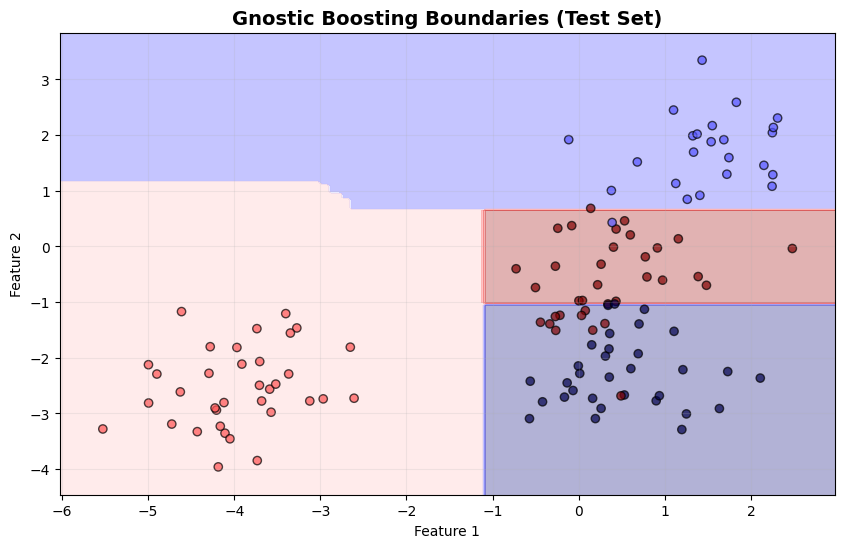

In [12]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='seismic')
    
    # Plot true labels to see if we recovered the blobs structure despite noise
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='seismic', edgecolors='k', alpha=0.7)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, alpha=0.2)
    plt.show()

plot_decision_boundary(model, X_test, y_test, "Gnostic Boosting Boundaries (Test Set)")

## Example 2: Understanding Gnostic Weights

The model identifies confusing or "hard" samples and assigns them lower weights. In a noisy dataset, these are typically the mislabeled points.

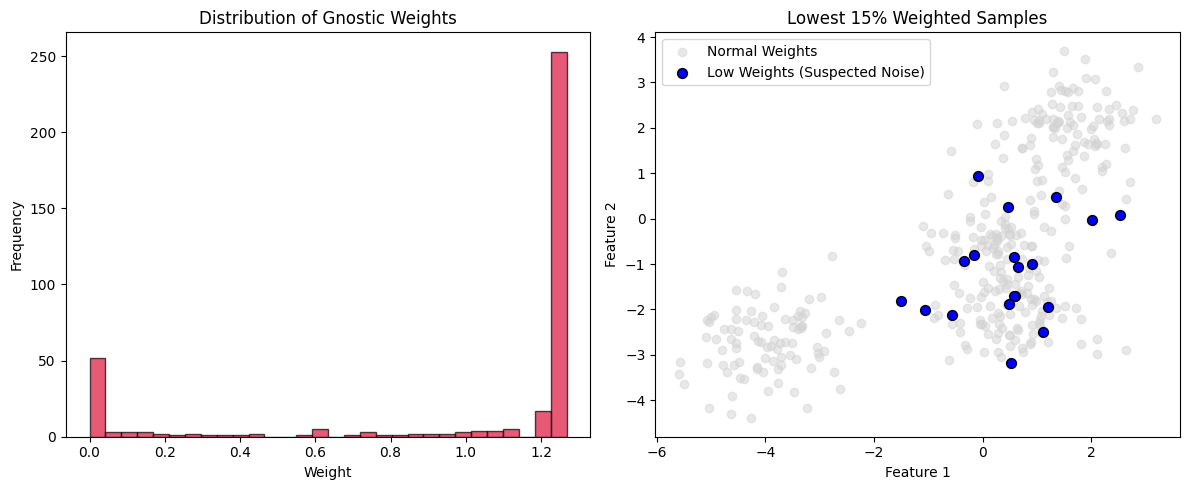

Mean weight: 1.0000


In [13]:
# Inspect Weights
weights = model.weights

# Visualize weights distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weights, bins=30, color='crimson', edgecolor='black', alpha=0.7)
plt.title('Distribution of Gnostic Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')

# Visualize low-weight samples on the dataset
threshold_val = np.percentile(weights, 5)
low_weight_mask = weights < threshold_val

plt.subplot(1, 2, 2)
# Plot all points
plt.scatter(X_train[:, 0], X_train[:, 1], c='lightgray', alpha=0.5, label='Normal Weights')
# Highlight low weights
plt.scatter(X_train[low_weight_mask, 0], X_train[low_weight_mask, 1], c='blue', s=50, edgecolors='k', label='Low Weights (Suspected Noise)')
plt.title(f'Lowest 15% Weighted Samples')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Mean weight: {np.mean(weights):.4f}")

## Model History

Tracking the Gnostic optimization process. Convergence typically happens within a few iterations.

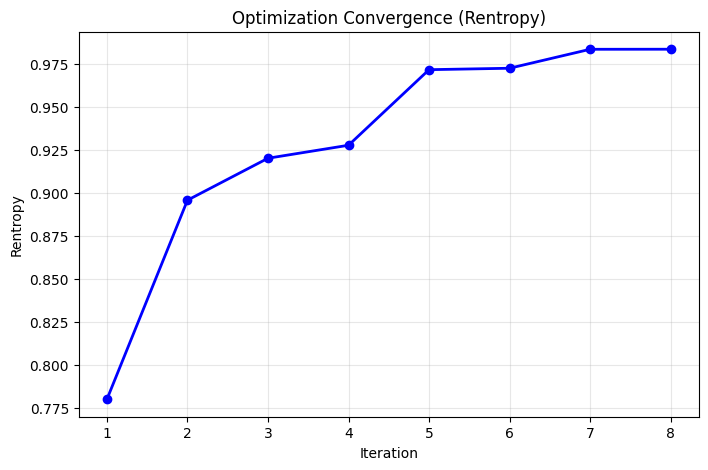

Initial Rentropy: None
Final Rentropy: 0.9832884920565578


In [14]:
history = model._history

if len(history) > 1:
    iterations = [h['iteration'] for h in history if h['iteration'] is not None]
    
    # Plot loss or rentropy
    if 'rentropy' in history[1]:
        metric = 'rentropy'
        title = 'Rentropy'
    else:
        metric = 'cross_entropy_loss'
        title = 'Loss'
        
    values = [h.get(metric, np.nan) for h in history if h['iteration'] is not None]
    
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, values, 'b-o', linewidth=2)
    plt.title(f'Optimization Convergence ({title})')
    plt.xlabel('Iteration')
    plt.ylabel(title)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial {title}: {values[0]}")
    print(f"Final {title}: {values[-1]}")
else:
    print("Model converged in 1 iteration or history not available.")